# Logistic Regression Pipeline for MCF7 (GREG)

### Author: Shaurya Jauhari (Mora Lab)
### Contact: Antonio Mora (antoniocmora@gzhmu.edu.cn)
### Last Reviewed : Dec. 10th, 2020

## Prologue

This notebook assesses variegated implementations of the logistic regression models for the data derived from the MCF7 cell-line in GREG. The data for this and other cell-types for GREG is available at this <a href = "https://zenodo.org/record/6339915"> link</a>. The current notebook uses the file "MCF7forML.txt".

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [1]:
requiredPackages <- c("glmnet", "rms", "caret", "e1071", "ROSE", "DMwR", "BiocManager", "ROCR")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages, dependencies = TRUE)

suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(rms))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(e1071))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(ROCR))

### <a id=link2>2. Loading Data </a>

In [2]:
mcf7gregStandard <- read.table("MCF7forML.txt", header = TRUE) ## loading full data
mcf7greg <- mcf7gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(mcf7greg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
6,0.05721561,0.09363865,0.03685132,0.05373381,0.05180643,0.09806973,0.0676687,0.03037976,0.132225,0.07040305,0.6368769,0.7405164,Non-Hub


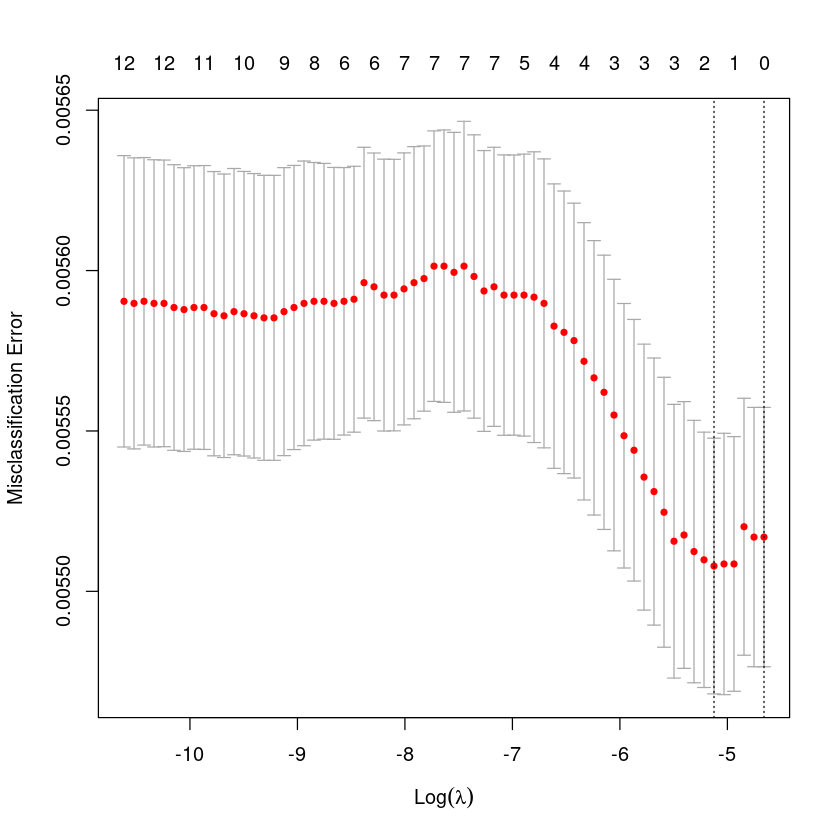

In [4]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(mcf7greg[,1:12]),
                         mcf7greg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 100)


plot(cv.modelfit)

In [5]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 65 lambda values in all:
 0.009472285 0.008630793 0.007864057 0.007165436 0.006528878 0.005948871 0.005420389 0.004938857 0.004500103 0.004100326 0.003736064 0.003404163 0.003101746 0.002826196 0.002575124 0.002346357 0.002137913 0.001947987 0.001774933 0.001617253 0.001473581 0.001342672 0.001223393 0.00111471 0.001015682 0.0009254516 0.0008432371 0.0007683262 0.0007000702 0.0006378779 0.0005812106 0.0005295774 0.0004825312 0.0004396645 0.0004006059 0.0003650172 0.0003325901 0.0003030437 0.0002761221 0.0002515922 0.0002292414 0.0002088763 0.0001903203 0.0001734127 0.0001580072 0.0001439703 0.0001311804 0.0001195267 0.0001089083 9.923315e-05 9.041755e-05 8.23851e-05 7.506624e-05 6.839756e-05 6.232131e-05 5.678485e-05 5.174024e-05 4.714378e-05 4.295566e-05 3.91396e-05 3.566254e-05 3.249438e-05 2.960767e-05 2.697741e-05 2.458081e-05 
, out of which 2.458081e-05 is the minimum, while 0.009472285 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [6]:
set.seed(2)
modelfit <- glmnet(as.matrix(mcf7greg[,1:12]),
                   mcf7greg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = cv.modelfit$lambda)

# Listing non-zero coefficients
print(modelfit$beta[,1])

         CTCF         EP300      H3K27me3      H3K36me3       H3K4me1 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me2       H3K4me3        H3K9ac       H3K9me3         RAD21 
 0.000000e+00  0.000000e+00  0.000000e+00 -1.058848e-15  0.000000e+00 
      RNA.Seq       RNAPol2 
 0.000000e+00  0.000000e+00 


In [7]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)          CTCF         EP300      H3K27me3      H3K36me3 
 5.194404e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me1       H3K4me2       H3K4me3        H3K9ac       H3K9me3 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -1.058848e-15 
        RAD21       RNA.Seq       RNAPol2 
 0.000000e+00  0.000000e+00  0.000000e+00

   [[ suppressing 65 column names ‘s0’, ‘s1’, ‘s2’ ... ]]



13 x 65 sparse Matrix of class "dgCMatrix"
                                                                        
(Intercept)  5.194404e+00  5.22803387  5.242114  5.25277442  5.263994759
CTCF         .             .           .         .           .          
EP300        .             .           .         .           .          
H3K27me3     .             .           .         .          -0.006191441
H3K36me3     .             .           .         .           .          
H3K4me1      .             .           .         .           .          
H3K4me2      .             .           .         .           .          
H3K4me3      .             .           .         .           .          
H3K9ac       .             .           .         .           .          
H3K9me3     -1.058848e-15 -0.04561906 -0.060643 -0.07072737 -0.075112850
RAD21        .             .           .         .           .          
RNA.Seq      .             .           .         .           .          
RNAPol2 

In [4]:
set.seed(5) # for reproducibility of results.
mcf7greg$Class <- as.numeric(as.factor(mcf7greg$Class))

# '1' for Hubs and '0' for Non-Hubs 
mcf7greg$Class <- ifelse(mcf7greg$Class == 2, 0, 1)

part <- sample(2, nrow(mcf7greg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- mcf7greg[part==1,]
test <- mcf7greg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

mcf7model <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(mcf7model)

So, now we have 1085941 training rows and 464926 testing rows

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.1037  -0.0974  -0.0953   3.4603  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -5.4212412  0.0144824 -374.334  < 2e-16 ***
CTCF         0.1231555  0.0104596   11.774  < 2e-16 ***
EP300        0.0006128  0.0065972    0.093  0.92599    
H3K27me3     0.0376144  0.0035553   10.580  < 2e-16 ***
H3K36me3    -0.0202301  0.0073217   -2.763  0.00573 ** 
H3K4me1     -0.0252831  0.0030960   -8.166 3.18e-16 ***
H3K4me2      0.0056000  0.0047127    1.188  0.23472    
H3K4me3     -0.0011819  0.0091394   -0.129  0.89710    
H3K9ac       0.0289041  0.0070872    4.078 4.54e-05 ***
H3K9me3      0.0802814  0.0051067   15.721  < 2e-16 ***
RAD21       -0.0471744  0.0076868   -6.137 8.41e-10 ***
RNA.Seq     -0.0061930  0.0036794   -1.683  0.09234 .  
RNAPol2      0.0343019  0.0022241   15.423  < 2e-16 ***
---
Signif. codes:  

In [5]:
vif(mcf7model)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 5.651209  5.327598  3.000520 12.586785  2.216306  7.134589 18.402681  7.843155 
  H3K9me3     RAD21   RNA.Seq   RNAPol2 
 4.674922  6.416018  1.017697  1.890691

Here, we can certainly get rid of <b>H3K4me2</b> and <b>H3K4me3</b>, as they have high *p* and vif values.

In [10]:
mcf7model1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2,
               data = train,
               family = "binomial")
summary(mcf7model1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.1036  -0.0974  -0.0953   3.4263  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -5.423398   0.014386 -376.982  < 2e-16 ***
CTCF         0.124736   0.010338   12.065  < 2e-16 ***
EP300        0.001401   0.006453    0.217   0.8281    
H3K27me3     0.037181   0.003537   10.511  < 2e-16 ***
H3K36me3    -0.019341   0.004492   -4.306 1.66e-05 ***
H3K4me1     -0.023841   0.002869   -8.310  < 2e-16 ***
H3K9ac       0.031208   0.006516    4.789 1.67e-06 ***
H3K9me3      0.081863   0.004955   16.520  < 2e-16 ***
RAD21       -0.047569   0.007674   -6.199 5.70e-10 ***
RNA.Seq     -0.006231   0.003674   -1.696   0.0899 .  
RNAPol2      0.034204   0.002211   15.469  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 

In [11]:
vif(mcf7model1)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1   H3K9ac  H3K9me3    RAD21 
5.536943 5.246144 2.979394 4.807476 1.897380 6.743977 4.398741 6.494531 
 RNA.Seq  RNAPol2 
1.018092 1.872461

Better !

In [12]:
yTrain <- predict(mcf7model1, train, type = "response")
head(yTrain)

1           2           4           5           7          10 
0.004392747 0.004392747 0.004392747 0.004392747 0.004559137 0.002491238

In [13]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
2,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
4,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
5,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
7,0,0,0,0,0,0,0,0,0,0,2.557013,1.5576379,0
10,0,0,0,0,0,0,0,0,0,0,92.176049,0.1532103,0


The confusion matrix is
         Actual
Predicted       0       1
        0 1079738    5914
        1     181     108
The accuracy of the model is 99.43874 % 
The misclassification error of the model is 0.5612644 % 
The sensitivity of the model is 99.98324 % 
The specificity of the model is 1.793424 % 
The area under curve is 0.5088833 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

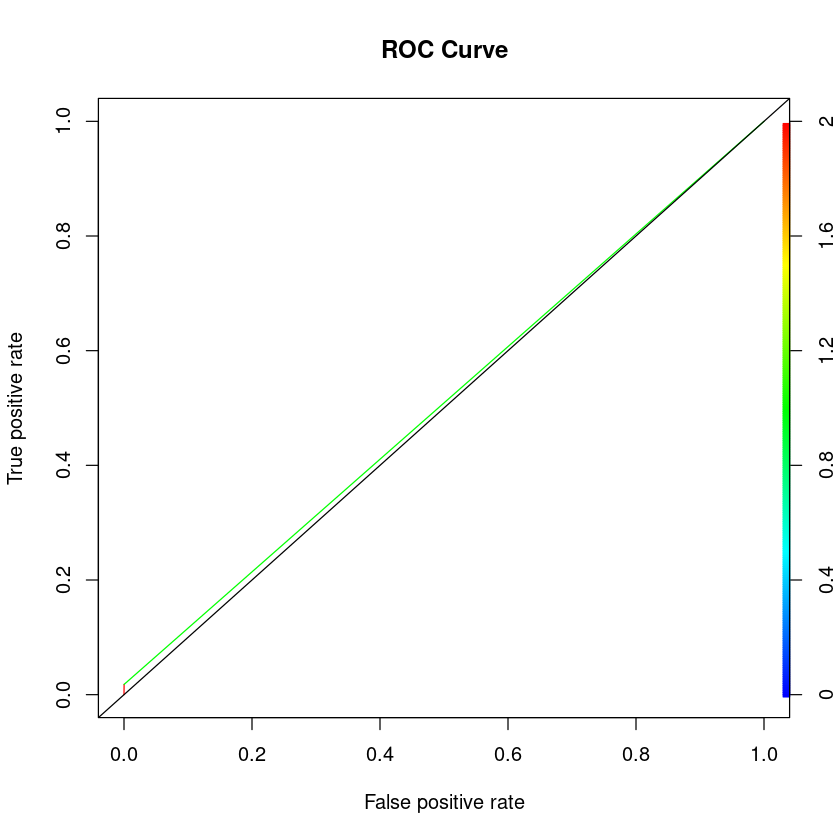

In [14]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(mcf7model1, "LR", train, Class)

For train data too, the model is skewed heavily towards a particular class. We can't expect it to deliver well to the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 462299   2490
        1     93     44
The accuracy of the model is 99.44443 % 
The misclassification error of the model is 0.5555723 % 
The sensitivity of the model is 99.97989 % 
The specificity of the model is 1.736385 % 
The area under curve is 0.5085814 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

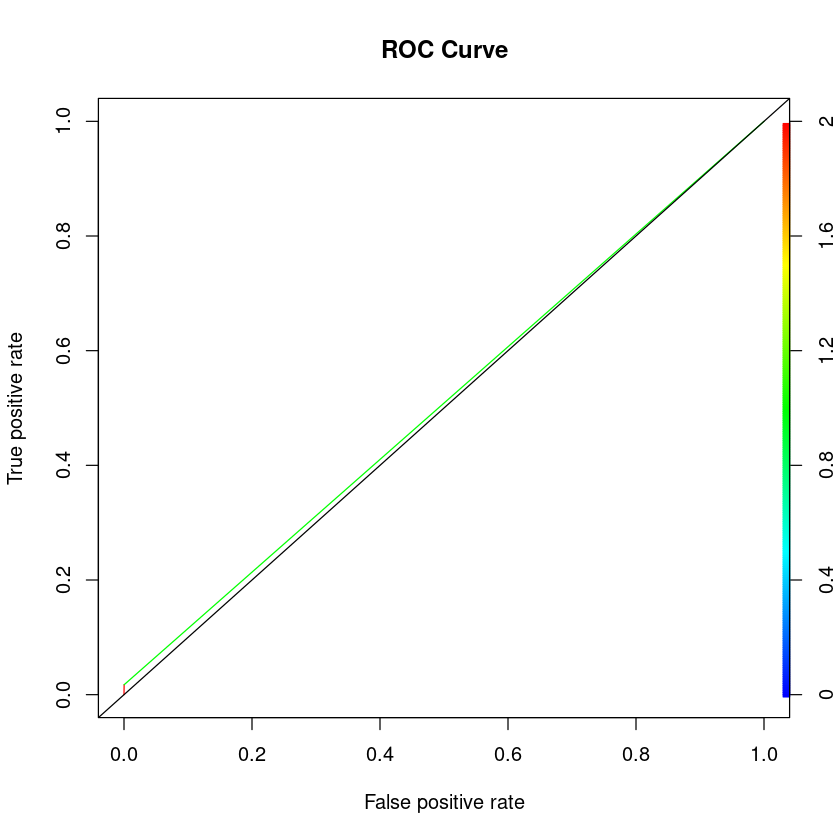

In [15]:
modelPerformance(mcf7model1, "LR", test, Class)

Exactly as we deliberated. We clearly observe that the model has **high sensitivity** and **low specificity**. It means that the model is highly biased towards the non-hubs and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (0: hubs).

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [6]:
table(mcf7greg$Class)


      0       1 
1542311    8556 

<p align = "justify"> We can articulate that the hubs (class marked with '1') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3). </p>

In [7]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1542311)$data

In [8]:
table(overTrain$Class)


      0       1 
1079919  462392 

In [13]:
head(overTrain)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
2,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
3,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
4,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,0
5,0,0,0,0,0,0,0,0,0,0,2.557013,1.5576379,0
6,0,0,0,0,0,0,0,0,0,0,92.176049,0.1532103,0


Still better. Let's run the model again to see if there is any improvement in the performance. With the change in class distribution and the corresponding feature values, thereby affecting the overall data profile, we shall encompass all features to train the model.

In [10]:
mcf7modelOver <- glm(formula = Class ~ .,
               data = overTrain,
               family = "binomial")
summary(mcf7modelOver)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = overTrain)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    8.49    8.49  

Coefficients:
              Estimate Std. Error    z value Pr(>|z|)    
(Intercept) -3.280e+15  6.208e+04 -5.283e+10   <2e-16 ***
CTCF         2.753e+14  5.367e+04  5.129e+09   <2e-16 ***
EP300        9.392e+13  2.969e+04  3.163e+09   <2e-16 ***
H3K27me3     3.629e+13  1.959e+04  1.852e+09   <2e-16 ***
H3K36me3    -1.854e+13  3.458e+04 -5.362e+08   <2e-16 ***
H3K4me1      1.523e+14  2.174e+04  7.006e+09   <2e-16 ***
H3K4me2     -1.451e+13  2.350e+04 -6.174e+08   <2e-16 ***
H3K4me3      6.344e+13  4.058e+04  1.563e+09   <2e-16 ***
H3K9ac       1.794e+13  4.515e+04  3.974e+08   <2e-16 ***
H3K9me3      1.653e+13  2.010e+04  8.228e+08   <2e-16 ***
RAD21       -6.204e+13  3.097e+04 -2.003e+09   <2e-16 ***
RNA.Seq     -7.722e+11  3.748e+02 -2.060e+09   <2e-16 ***
RNAPol2      1.226e+13  9.830e+03  1.247e+09   <2e-16 **

We observe that the algorithm did not converge. Let us try with increased number of iterations. Note that the *maxit* parameter runs 25 iterations by default. We'll change that to 100 and try again.

In [11]:
mcf7model1Over <- glm(formula = Class ~ .,
               data = overTrain,
               family = "binomial",
                control = list(epsilon = 1e-15, maxit = 100))

summary(mcf7model1Over)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = overTrain, 
    control = list(epsilon = 1e-15, maxit = 100))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    0.00    8.49  

Coefficients:
              Estimate Std. Error    z value Pr(>|z|)    
(Intercept) -9.801e+14  6.208e+04 -1.579e+10   <2e-16 ***
CTCF         9.498e+13  5.367e+04  1.770e+09   <2e-16 ***
EP300        1.809e+14  2.969e+04  6.091e+09   <2e-16 ***
H3K27me3     6.861e+13  1.959e+04  3.502e+09   <2e-16 ***
H3K36me3    -2.416e+13  3.458e+04 -6.987e+08   <2e-16 ***
H3K4me1      3.740e+13  2.174e+04  1.720e+09   <2e-16 ***
H3K4me2     -2.949e+13  2.350e+04 -1.255e+09   <2e-16 ***
H3K4me3      1.089e+13  4.058e+04  2.684e+08   <2e-16 ***
H3K9ac       3.491e+13  4.515e+04  7.733e+08   <2e-16 ***
H3K9me3      1.804e+14  2.010e+04  8.976e+09   <2e-16 ***
RAD21       -4.907e+13  3.097e+04 -1.584e+09   <2e-16 ***
RNA.Seq     -2.267e+12  3.748e+02 -6.048e+09   <2e-16 ***
RNAPo

In [12]:
mcf7model2Over <- glm(formula = Class ~ .,
               data = overTrain,
               family = "binomial",
                control = list(maxit = 100)) ## keeping epsilon to it's default value

summary(mcf7model2Over)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = overTrain, 
    control = list(maxit = 100))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    0.00    8.49  

Coefficients:
              Estimate Std. Error    z value Pr(>|z|)    
(Intercept) -9.801e+14  6.208e+04 -1.579e+10   <2e-16 ***
CTCF         9.498e+13  5.367e+04  1.770e+09   <2e-16 ***
EP300        1.809e+14  2.969e+04  6.091e+09   <2e-16 ***
H3K27me3     6.861e+13  1.959e+04  3.502e+09   <2e-16 ***
H3K36me3    -2.416e+13  3.458e+04 -6.987e+08   <2e-16 ***
H3K4me1      3.740e+13  2.174e+04  1.720e+09   <2e-16 ***
H3K4me2     -2.949e+13  2.350e+04 -1.255e+09   <2e-16 ***
H3K4me3      1.089e+13  4.058e+04  2.684e+08   <2e-16 ***
H3K9ac       3.491e+13  4.515e+04  7.733e+08   <2e-16 ***
H3K9me3      1.804e+14  2.010e+04  8.976e+09   <2e-16 ***
RAD21       -4.907e+13  3.097e+04 -1.584e+09   <2e-16 ***
RNA.Seq     -2.267e+12  3.748e+02 -6.048e+09   <2e-16 ***
RNAPol2      3.611e+13

In [9]:
mcf7model3Over <- glm(formula = Class ~ .,
               data = overTrain,
               family = "binomial",
                maxit = 500) ## further increasing the number of iterations, significantly.

summary(mcf7model3Over)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = overTrain, maxit = 500)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    8.49    8.49  

Coefficients:
              Estimate Std. Error    z value Pr(>|z|)    
(Intercept) -3.317e+15  6.116e+04 -5.423e+10   <2e-16 ***
CTCF         1.223e+14  5.283e+04  2.316e+09   <2e-16 ***
EP300        2.021e+14  2.962e+04  6.823e+09   <2e-16 ***
H3K27me3     6.908e+13  1.953e+04  3.536e+09   <2e-16 ***
H3K36me3     3.254e+13  2.480e+04  1.312e+09   <2e-16 ***
H3K4me1     -6.666e+12  2.066e+04 -3.226e+08   <2e-16 ***
H3K9ac      -7.402e+12  4.156e+04 -1.781e+08   <2e-16 ***
H3K9me3      1.842e+14  1.929e+04  9.547e+09   <2e-16 ***
RAD21       -4.530e+13  3.089e+04 -1.466e+09   <2e-16 ***
RNA.Seq     -5.320e+12  3.745e+02 -1.420e+10   <2e-16 ***
RNAPol2      3.607e+13  9.820e+03  3.673e+09   <2e-16 ***
-

<p align="justify"> We observe that several flavors of the model fail to converge with the oversampled data. We can try another proportion of class distribution by tuning paramaters of the oversampling process. A reason for another warning about "fitted probabilities numerically 0 or 1 occurred" could be contemplated in the text, Venables & Ripley (2002, pp. 197–8). <b><i> " ...There is one fairly common circumstance in which both convergence problems and the Hauck-Donner phenomenon can occur. This is when the fitted probabilities are extremely close to zero or one ..."</i></b> </p> 

In [19]:
overTrain1 <- ovun.sample(Class ~., data = train, method = "over", N = 2250000)$data

In [20]:
table(overTrain1$Class)


      0       1 
1079919 1170081 

We see that the difference in class-instances has narrowed somewhat. Let's try again to train the model, first with default parameters.

In [21]:
mcf7model4Over <- glm(formula = Class ~ .,
               data = overTrain1,
               family = "binomial")

summary(mcf7model4Over)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = overTrain1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0270   0.0104   1.1352   1.8847  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.6966214  0.0021695 -321.100  < 2e-16 ***
CTCF         0.0881872  0.0026599   33.155  < 2e-16 ***
EP300        0.4103725  0.0024377  168.345  < 2e-16 ***
H3K27me3     0.0578216  0.0015068   38.374  < 2e-16 ***
H3K36me3    -0.0626717  0.0012447  -50.349  < 2e-16 ***
H3K4me1     -0.0485967  0.0012073  -40.252  < 2e-16 ***
H3K4me2     -0.0115683  0.0010576  -10.938  < 2e-16 ***
H3K4me3      0.0041238  0.0011948    3.451 0.000558 ***
H3K9ac       0.0761925  0.0019497   39.079  < 2e-16 ***
H3K9me3      0.2162746  0.0018166  119.054  < 2e-16 ***
RAD21       -0.0330921  0.0021200  -15.610  < 2e-16 ***
RNA.Seq     -0.0079671  0.0006736  -11.827  < 2e-16 ***
RNAPol2      0.0586121  0.0010809   54.223  < 2e-16 ***
---
Signif. cod

In [22]:
mcf7model5Over <- glm(formula = Class ~ .,
               data = overTrain1,
               family = "binomial",
                     maxit = 100) # with increased repetitions

summary(mcf7model5Over)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = overTrain1, 
    maxit = 100)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0263   0.0101   1.1364   1.8982  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.6904794  0.0021723 -317.860  < 2e-16 ***
CTCF         0.0918922  0.0026595   34.552  < 2e-16 ***
EP300        0.3957122  0.0024434  161.951  < 2e-16 ***
H3K27me3     0.0592182  0.0015082   39.265  < 2e-16 ***
H3K36me3    -0.0629580  0.0012368  -50.906  < 2e-16 ***
H3K4me1     -0.0447943  0.0012046  -37.185  < 2e-16 ***
H3K4me2     -0.0143230  0.0010509  -13.629  < 2e-16 ***
H3K4me3      0.0051706  0.0011912    4.341 1.42e-05 ***
H3K9ac       0.0771724  0.0019297   39.993  < 2e-16 ***
H3K9me3      0.2137080  0.0018185  117.518  < 2e-16 ***
RAD21       -0.0343751  0.0021225  -16.195  < 2e-16 ***
RNA.Seq     -0.0271009  0.0004561  -59.415  < 2e-16 ***
RNAPol2      0.0657226  0.0010394   63.230  < 2e-16 *

No success here. Let us then minimize the majority class-instances and see if it makes any difference.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [23]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N= 12000)$data
table(underTrain$Class)


   0    1 
5978 6022 

In [24]:
mcf7modelUnder <- glm(formula = Class ~ .,
               data = underTrain,
               family = "binomial")
summary(mcf7modelUnder)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = underTrain)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-7.544  -1.007   0.000   1.150   2.619  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.760635   0.029659 -25.646  < 2e-16 ***
CTCF         0.087335   0.023612   3.699 0.000217 ***
EP300        0.366271   0.032935  11.121  < 2e-16 ***
H3K27me3     0.090336   0.021195   4.262 2.02e-05 ***
H3K36me3    -0.104684   0.019544  -5.356 8.50e-08 ***
H3K4me1     -0.025081   0.016823  -1.491 0.135994    
H3K4me2     -0.019738   0.014197  -1.390 0.164432    
H3K4me3      0.013258   0.018520   0.716 0.474078    
H3K9ac       0.132008   0.029929   4.411 1.03e-05 ***
H3K9me3      0.178708   0.024559   7.277 3.42e-13 ***
RAD21       -0.051806   0.008672  -5.974 2.31e-09 ***
RNA.Seq     -0.016886   0.007363  -2.293 0.021821 *  
RNAPol2      0.077320   0.015190   5.090 3.58e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 

In [25]:
vif(mcf7modelUnder)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 1.790981  1.956998  2.311741 13.811543  2.130869  3.308505  9.644409  8.753129 
  H3K9me3     RAD21   RNA.Seq   RNAPol2 
 2.633818  1.704033  1.049694  2.195454

With the explanations stated previously, we can eliminate the variable **H3K4me3** and restructure the model.

In [26]:
mcf7model1Under <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2,
               data = underTrain,
               family = "binomial")
summary(mcf7model1Under)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-7.559  -1.006   0.000   1.151   2.400  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.761413   0.029638 -25.690  < 2e-16 ***
CTCF         0.087179   0.023572   3.698 0.000217 ***
EP300        0.367914   0.032893  11.185  < 2e-16 ***
H3K27me3     0.090731   0.021198   4.280 1.87e-05 ***
H3K36me3    -0.095608   0.014591  -6.552 5.66e-11 ***
H3K4me1     -0.025252   0.016789  -1.504 0.132567    
H3K4me2     -0.017867   0.013919  -1.284 0.199270    
H3K9ac       0.134403   0.029729   4.521 6.16e-06 ***
H3K9me3      0.179712   0.024513   7.331 2.28e-13 ***
RAD21       -0.052075   0.008582  -6.068 1.29e-09 ***
RNA.Seq     -0.016759   0.007354  -2.279 0.022664 *  
RNAPol2      0.076265   0.015068   5.061 4.16e-07 *

The confusion matrix is
         Actual
Predicted      0      1
        0 361832   1156
        1 100560   1378
The accuracy of the model is 78.12211 % 
The misclassification error of the model is 21.87789 % 
The sensitivity of the model is 78.25222 % 
The specificity of the model is 54.38043 % 
The area under curve is 0.6631632 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

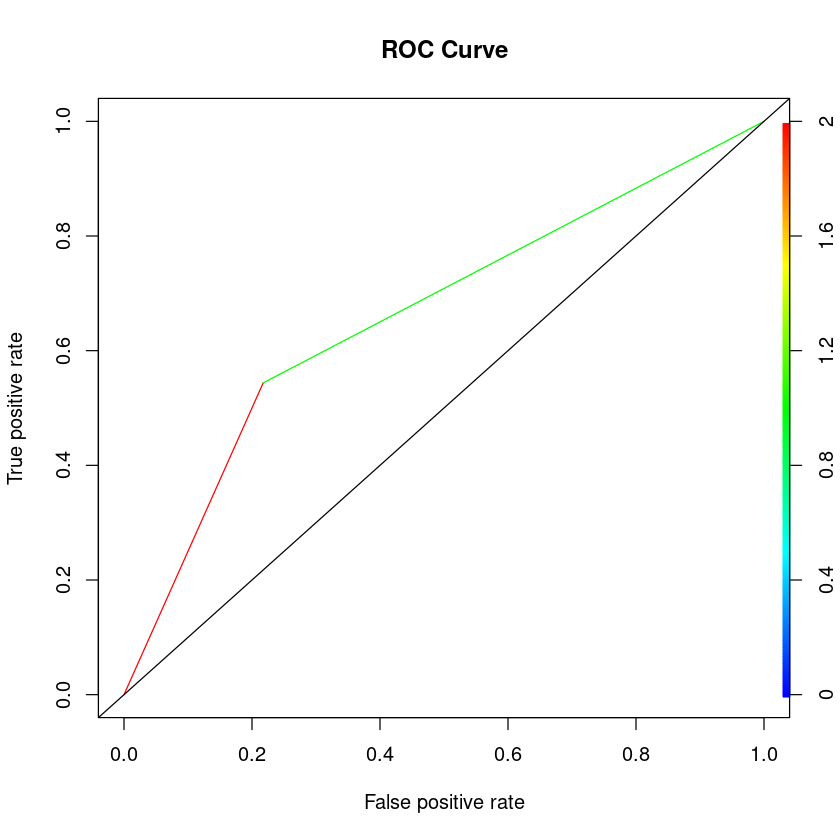

In [28]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(mcf7model1Under, "LR", test, Class)

This case is somewhat balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [29]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.

train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 18000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
1083960 1089982 

In [30]:
mcf7modelSMOTE <- glm(formula = Class ~ .,
                    data = smoteData,
                    family = "binomial")
summary(mcf7modelSMOTE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = smoteData)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-8.490  -1.008   0.000   1.151   2.151  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.7709677  0.0022151 -348.048   <2e-16 ***
CTCF         0.1007509  0.0027611   36.490   <2e-16 ***
EP300        0.4184037  0.0025025  167.197   <2e-16 ***
H3K27me3     0.0545992  0.0015587   35.029   <2e-16 ***
H3K36me3    -0.0724690  0.0013963  -51.901   <2e-16 ***
H3K4me1     -0.0506650  0.0012315  -41.141   <2e-16 ***
H3K4me2     -0.0142549  0.0011053  -12.897   <2e-16 ***
H3K4me3      0.0114414  0.0013307    8.598   <2e-16 ***
H3K9ac       0.0779299  0.0020378   38.242   <2e-16 ***
H3K9me3      0.2216781  0.0018735  118.323   <2e-16 ***
RAD21       -0.0494309  0.0022212  -22.254   <2e-16 ***
RNA.Seq     -0.0139784  0.0002796  -49.991   <2e-16 ***
RNAPol2      0.0601389  0.0010714   56.129   <2e-16 ***
---
Signif. codes:  0 ‘***

In [31]:
vif(mcf7modelSMOTE)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 3.677815  1.916189  2.322099 11.785777  2.140581  3.694670  8.635496  7.479911 
  H3K9me3     RAD21   RNA.Seq   RNAPol2 
 2.675755  3.730511  1.037167  2.248273

All variables have high statistical significance. Following this observation, we shall omit the VIF scores for now, although we have high numbers for some variables.

The confusion matrix is
         Actual
Predicted      0      1
        0 362516   1177
        1  99876   1357
The accuracy of the model is 78.26471 % 
The misclassification error of the model is 21.73529 % 
The sensitivity of the model is 78.40015 % 
The specificity of the model is 53.5517 % 
The area under curve is 0.6597592 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

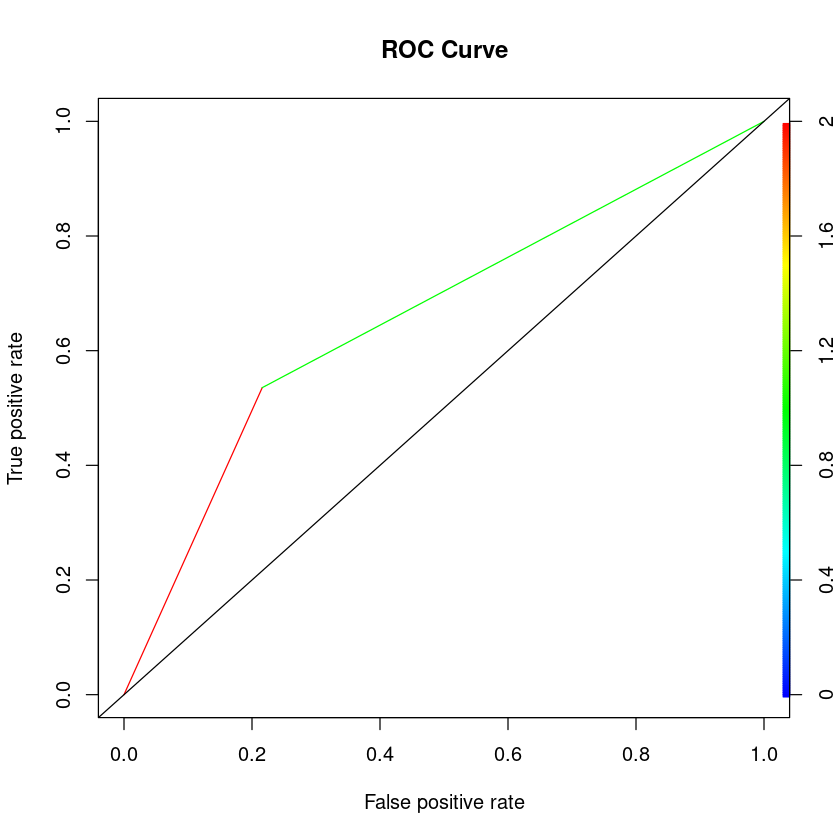

In [32]:
modelPerformance(mcf7modelSMOTE, "LR", test, Class)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly lower specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [33]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1542311)$data
table(bothTrain$Class)


     0      1 
771950 770361 

In [34]:
mcf7modelBoth <- glm(formula = Class ~ .,
               data = bothTrain,
               family = "binomial")
summary(mcf7modelBoth)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0051  -0.7382   1.1507   1.8755  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.7836279  0.0026300 -297.955   <2e-16 ***
CTCF         0.0950154  0.0031818   29.862   <2e-16 ***
EP300        0.4109076  0.0029375  139.882   <2e-16 ***
H3K27me3     0.0562243  0.0018029   31.185   <2e-16 ***
H3K36me3    -0.0624925  0.0014852  -42.077   <2e-16 ***
H3K4me1     -0.0479381  0.0014452  -33.170   <2e-16 ***
H3K4me2     -0.0114967  0.0012755   -9.013   <2e-16 ***
H3K4me3      0.0020764  0.0014500    1.432    0.152    
H3K9ac       0.0817606  0.0023569   34.689   <2e-16 ***
H3K9me3      0.2188557  0.0021767  100.546   <2e-16 ***
RAD21       -0.0389445  0.0025334  -15.373   <2e-16 ***
RNA.Seq     -0.0107420  0.0006153  -17.457   <2e-16 ***
RNAPol2      0.0574626  0.0012377   46.425   <2e-16 ***
---
Signif. code

The confusion matrix is
         Actual
Predicted      0      1
        0 365450   1204
        1  96942   1330
The accuracy of the model is 78.88997 % 
The misclassification error of the model is 21.11003 % 
The sensitivity of the model is 79.03467 % 
The specificity of the model is 52.48619 % 
The area under curve is 0.6576043 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

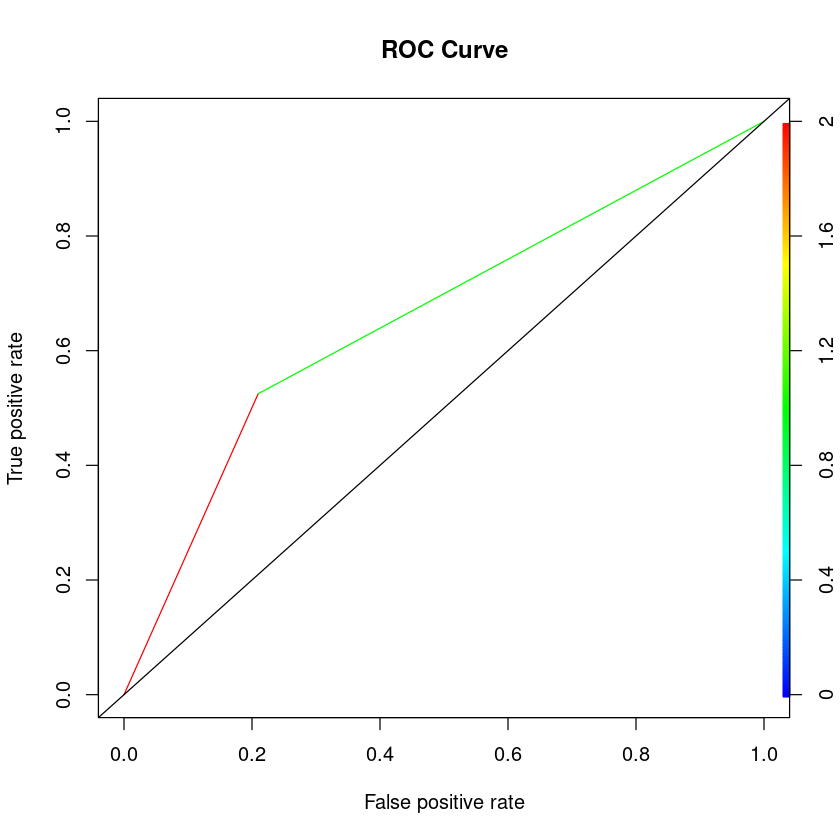

In [35]:
modelPerformance(mcf7modelBoth, "lr", test, Class)

These numbers aren't as good. Hitherto, the model with SMOTE data has performed the best.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [36]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(mcf7greg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- mcf7greg[parts==1,]
testing <- mcf7greg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1240839 training rows and 310028 testing rows

In [37]:
mcf7paretoModel <- glm(formula = Class ~ ., data = training, family = "binomial")
summary(mcf7paretoModel)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.1041  -0.0975  -0.0955   3.6770  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -5.4158153  0.0135281 -400.338  < 2e-16 ***
CTCF         0.1225363  0.0094531   12.963  < 2e-16 ***
EP300        0.0003951  0.0050589    0.078 0.937749    
H3K27me3     0.0409694  0.0032588   12.572  < 2e-16 ***
H3K36me3    -0.0090898  0.0061213   -1.485 0.137561    
H3K4me1     -0.0211940  0.0028611   -7.408 1.29e-13 ***
H3K4me2      0.0053800  0.0049164    1.094 0.273830    
H3K4me3     -0.0207663  0.0080570   -2.577 0.009954 ** 
H3K9ac       0.0241072  0.0067951    3.548 0.000389 ***
H3K9me3      0.0767593  0.0045200   16.982  < 2e-16 ***
RAD21       -0.0435751  0.0062911   -6.926 4.31e-12 ***
RNA.Seq     -0.0055815  0.0033313   -1.675 0.093838 .  
RNAPol2      0.0386374  0.0020650   18.710  < 2e-16 ***
---
Signif. codes

In [38]:
vif(mcf7paretoModel)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 5.342821  4.017142  2.937590  8.725425  2.138344  8.065220 13.687868  7.666776 
  H3K9me3     RAD21   RNA.Seq   RNAPol2 
 4.329607  5.289583  1.015485  2.032114

**H3K36me3**, **H3K4me2** could again be omitted for the reasons mentioned before. 

In [39]:
mcf7paretoModel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K4me1 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2,
                    data = training, family = "binomial")
summary(mcf7paretoModel1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K4me1 + H3K4me3 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.1040  -0.0975  -0.0954   3.6021  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -5.418373   0.013419 -403.785  < 2e-16 ***
CTCF         0.124291   0.009256   13.428  < 2e-16 ***
EP300        0.001825   0.004933    0.370 0.711403    
H3K27me3     0.040115   0.003232   12.412  < 2e-16 ***
H3K4me1     -0.018870   0.002566   -7.355 1.91e-13 ***
H3K4me3     -0.023929   0.004837   -4.947 7.55e-07 ***
H3K9ac       0.020961   0.005865    3.574 0.000352 ***
H3K9me3      0.079133   0.004361   18.146  < 2e-16 ***
RAD21       -0.043954   0.006267   -7.013 2.33e-12 ***
RNA.Seq     -0.005723   0.003344   -1.711 0.087048 .  
RNAPol2      0.038352   0.002038   18.817  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.0

In [40]:
vif(mcf7paretoModel1)

CTCF    EP300 H3K27me3  H3K4me1  H3K4me3   H3K9ac  H3K9me3    RAD21 
5.184816 3.932726 2.897938 1.718792 5.197179 6.008499 4.021722 5.328431 
 RNA.Seq  RNAPol2 
1.015817 1.998551

The confusion matrix is
         Actual
Predicted      0      1
        0 308338   1618
        1     44     28
The accuracy of the model is 99.46392 % 
The misclassification error of the model is 0.5360806 % 
The sensitivity of the model is 99.98573 % 
The specificity of the model is 1.701094 % 
The area under curve is 0.5084341 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

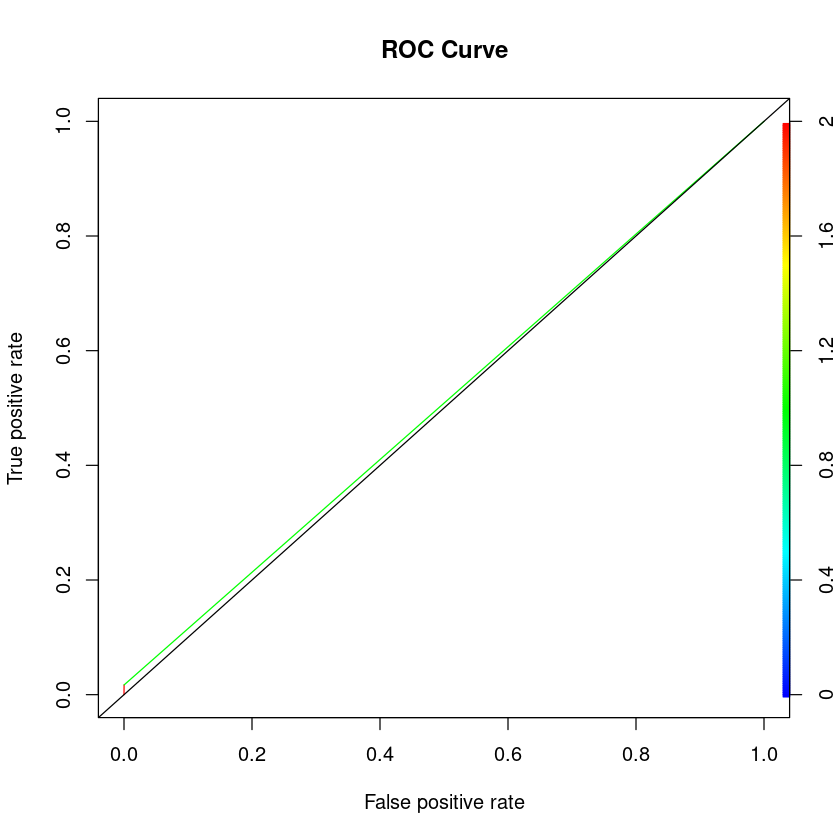

In [41]:
modelPerformance(mcf7paretoModel1, "lr", testing, Class)

We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "0"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [42]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~., training, perc.over = 4000, k = 5, perc.under = 102)
table(smoteDatum$Class)


     0      1 
281928 283310 

In [43]:
mcf7paretoModelSmote <- glm(formula = Class ~ ., data = smoteDatum, family = "binomial")
summary(mcf7paretoModelSmote)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = smoteDatum)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-8.490  -1.009   0.000   1.153   1.818  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.764912   0.004349 -175.865  < 2e-16 ***
CTCF         0.080856   0.005500   14.701  < 2e-16 ***
EP300        0.413529   0.004843   85.382  < 2e-16 ***
H3K27me3     0.049398   0.002993   16.506  < 2e-16 ***
H3K36me3    -0.056882   0.002414  -23.567  < 2e-16 ***
H3K4me1     -0.047808   0.002438  -19.611  < 2e-16 ***
H3K4me2     -0.014457   0.002274   -6.359 2.03e-10 ***
H3K4me3     -0.011368   0.002559   -4.442 8.91e-06 ***
H3K9ac       0.068355   0.003667   18.642  < 2e-16 ***
H3K9me3      0.220658   0.003608   61.165  < 2e-16 ***
RAD21       -0.017769   0.004332   -4.102 4.10e-05 ***
RNA.Seq     -0.014398   0.001098  -13.111  < 2e-16 ***
RNAPol2      0.068106   0.002175   31.320  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 

In [44]:
vif(mcf7paretoModelSmote)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
3.793754 1.819679 2.260009 8.059916 2.174660 4.007287 6.900401 6.051997 
 H3K9me3    RAD21  RNA.Seq  RNAPol2 
2.592843 3.807066 1.043999 2.306421

The confusion matrix is
         Actual
Predicted      0      1
        0 362549   1183
        1  99843   1351
The accuracy of the model is 78.27052 % 
The misclassification error of the model is 21.72948 % 
The sensitivity of the model is 78.40728 % 
The specificity of the model is 53.31492 % 
The area under curve is 0.658611 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

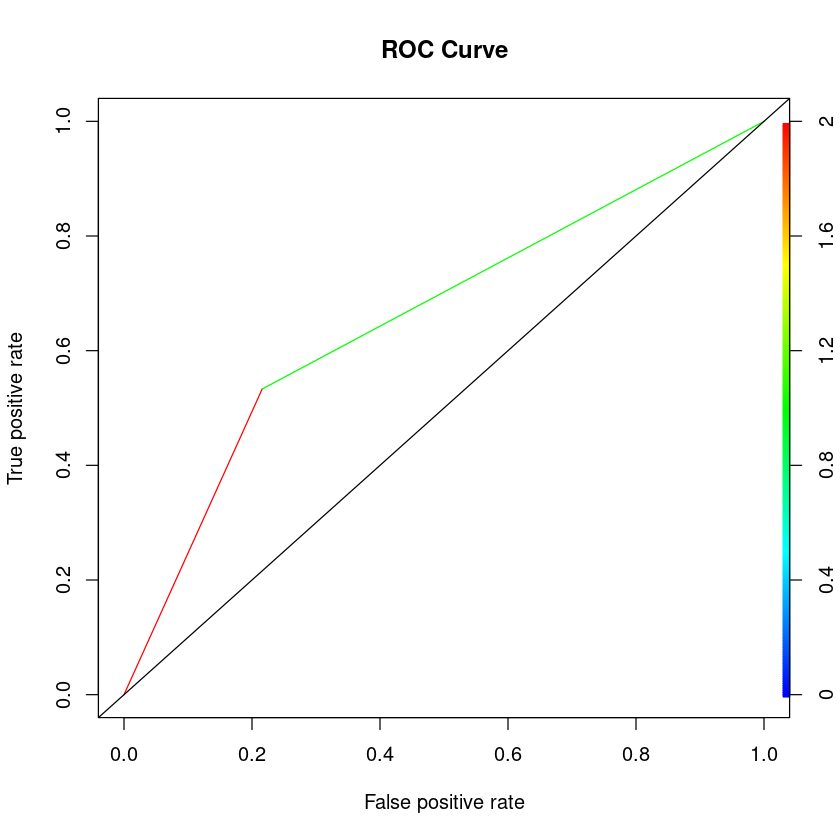

In [45]:
modelPerformance(mcf7paretoModelSmote, "lr", test, Class)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with a previous model and will save the prediction results, that shall be later utilized for plotting.

In [46]:
mcf7gregModelPredictions <- predict(mcf7model1Under, mcf7greg, type = "response")
mcf7gregModelPredictionsProbs <- ifelse(mcf7gregModelPredictions > 0.5, 1, 0)

In [68]:
# --- NOT RUN --- #
source("../../transcriptionFactoriesGREG/MachineLearning/R/visualizeWithGviz.R")
visualizeWithGviz("MCF7forML.txt", "chr21", 1, 2, 3, 16, mcf7gregModelPredictionsProbs)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'Gviz'




The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpWZ6RwA/downloaded_packages


Old packages: 'knitr', 'labelled', 'multcomp', 'openxlsx', 'tinytex', 'withr'



The function **visualizeWithGviz** works too and outputs the plots and tables as external files written to current working directory.

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the MCF7 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [47]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

<p align="justify"> Next, we recall the data from the MCF7 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! </p>

In [48]:
mcf7gregStandardRegionsClass <- mcf7gregStandard[, c(1:3,16)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [49]:
# Extracting chr21 data

mcf7gregChr21NonHub <- mcf7gregStandardRegionsClass[mcf7gregStandardRegionsClass$chr=="chr21" & mcf7gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
mcf7gregChr21Hub <- mcf7gregStandardRegionsClass[mcf7gregStandardRegionsClass$chr=="chr21" & mcf7gregStandardRegionsClass$Class=="Hub", ]

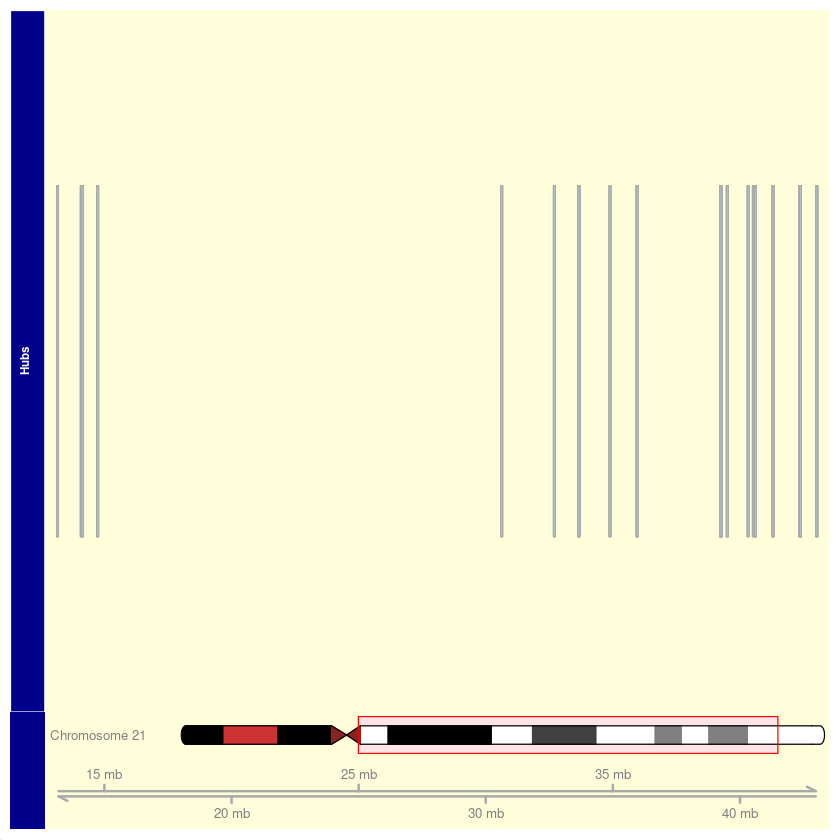

In [50]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = mcf7gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

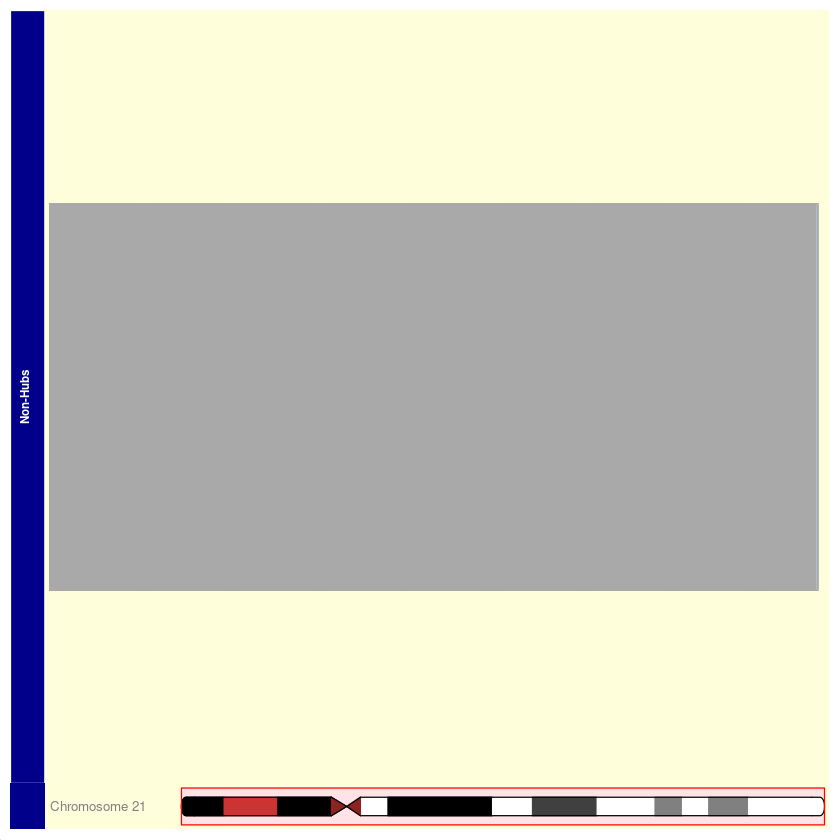

In [51]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = mcf7gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [52]:
mcf7gregPredicted <- cbind(mcf7gregStandardRegionsClass, mcf7gregModelPredictionsProbs)
names(mcf7gregPredicted)[names(mcf7gregPredicted)=="mcf7gregModelPredictionsProbs"] <- "Prediction"
mcf7gregPredicted$Prediction <- ifelse(mcf7gregPredicted$Prediction == 1, "Hub", "Non-Hub")            

Let us see if the classifier predictions match with the original results.

In [53]:
mcf7gregChr21PredicitedHub <- mcf7gregPredicted[mcf7gregPredicted$chr=="chr21" & mcf7gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

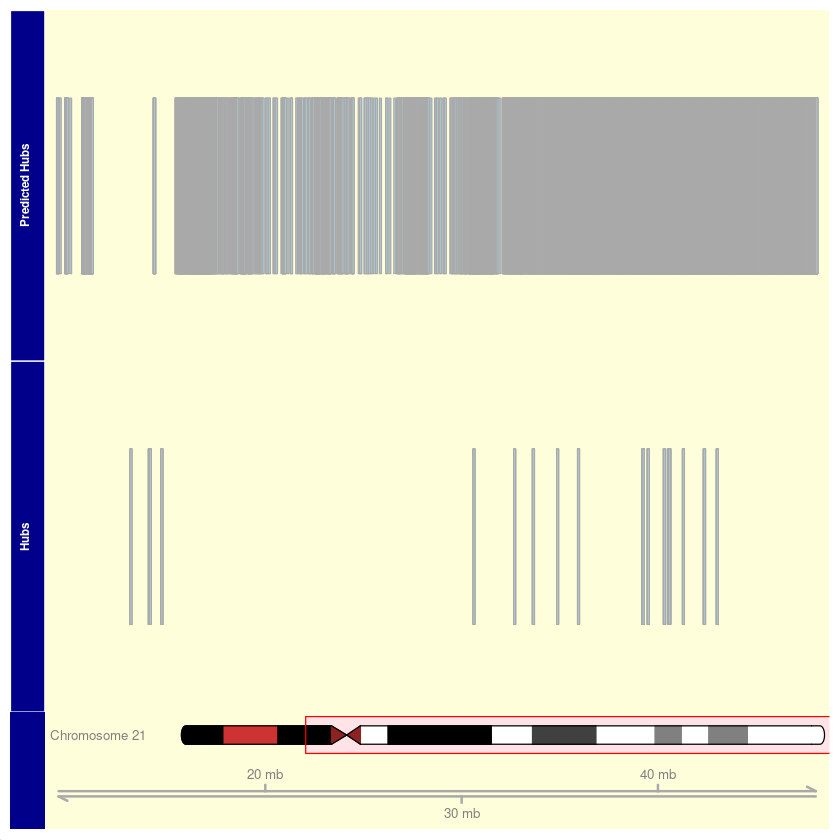

In [54]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = mcf7gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = mcf7gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [55]:
truePositives <- mcf7gregPredicted[mcf7gregPredicted$Class == mcf7gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [56]:
## Saving relevant files

save(mcf7model1Under, file = "./optimalModels/mcf7modelLR") # optimal model
write.table(truePositives, file = "./truePositives/mcf7LR.txt", quote = FALSE) # true positives: precicted ~ original
write.table(underTrain, file = "./buildData/optimalModelTrainMCF7.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestMCF7.txt", quote = FALSE) # data used to test model

### Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| mcf7model1Under | 78.12211 % | 78.25222 % | 54.38043 % | Good

### <a id=link13>7. Session Information </a>

In [57]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          DMwR_0.4.1           ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         H